Given code that can extract the contents of the inner rectangles (boxes), we can determine whether the 
contents have changed.

Here, take an image of the previous box and see whether the same contents are still there.  The idea is that 
a name does not only get erased, it may also be replaced.  We hope to find something more robust than the ink
method (exploration-2). 


In [2]:
LIVENOTEBOOK = True
import cv2
cv2.__version__
import extract_blue_grid
get_contents = extract_blue_grid.get_contents



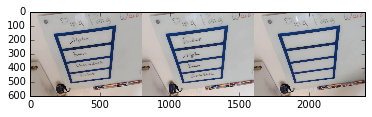

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.measure import compare_ssim 
def imshow(img):  plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

imwriting1 = cv2.imread("../reference/frame276.png")
imwriting2 = cv2.imread("../reference/frame280.png")
imempty = cv2.imread("../reference/frame272.png")


if LIVENOTEBOOK:
    %matplotlib inline
    # test plotting
    imshow(np.concatenate([imwriting1,imwriting2,imempty], axis=1))

In [4]:
# not used:
def threshold_boxes(boxes):
    """Given a list of images, adaptive threshold each image"""
    output = []
    for img in boxes:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        dst = cv2.adaptiveThreshold(img, 160, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 5, 2)
        output.append(dst)
    return output


Found 3 outer contours
Found shape with sides: 13
Found shape with sides: 12
Found shape with sides: 4
-- Found: 445 x 409
Found 3 outer contours
Found shape with sides: 12
Found shape with sides: 12
Found shape with sides: 4
-- Found: 445 x 409
Found 3 outer contours
Found shape with sides: 14
Found shape with sides: 12
Found shape with sides: 4
-- Found: 445 x 409


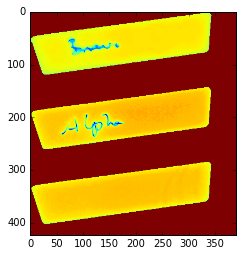

In [5]:
%matplotlib inline
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (9, 9))

writing1 = get_contents("../reference/frame276.png")[1]
writing1 = cv2.morphologyEx(writing1, cv2.MORPH_OPEN, kernel)
img = cv2.cvtColor(writing1, cv2.COLOR_BGR2GRAY)
#writing1 = cv2.adaptiveThreshold(img, 160, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 5, 2)
writing1 = img

writing2 = get_contents("../reference/frame280.png")[1]
img = cv2.cvtColor(writing2, cv2.COLOR_BGR2GRAY)
#writing2 = cv2.adaptiveThreshold(img, 160, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 5, 2)
writing2 = img

empty = get_contents("../reference/frame272.png")[1]
img = cv2.cvtColor(empty, cv2.COLOR_BGR2GRAY)
#empty = cv2.adaptiveThreshold(img, 160, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 5, 2)
empty = img

plt.imshow(np.concatenate([writing1,writing2,empty]))
#plt.imshow(writing1)
#writing1.shape, writing2.shape, empty.shape


Found 4 outer contours
Found shape with sides: 4
-- Rejected rectangle: 2 x 2
Found shape with sides: 15
Found shape with sides: 13
Found shape with sides: 4
-- Found: 445 x 409
Found 3 outer contours
Found shape with sides: 15
Found shape with sides: 12
Found shape with sides: 4
-- Found: 445 x 409


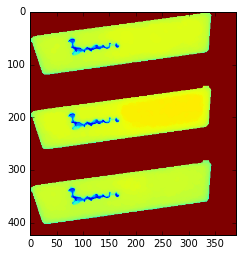

In [6]:
writingb = get_contents("../reference/frame274.png")[1]
writingb = cv2.morphologyEx(writingb, cv2.MORPH_OPEN, kernel)
writingb = cv2.cvtColor(writingb, cv2.COLOR_BGR2GRAY)

writingc = get_contents("../reference/frame275.png")[1]
writingc = cv2.morphologyEx(writingc, cv2.MORPH_OPEN, kernel)
writingc = cv2.cvtColor(writingc, cv2.COLOR_BGR2GRAY)

plt.imshow(np.concatenate([writing1,writingb,writingc]))

(0, 0) (390, 141)


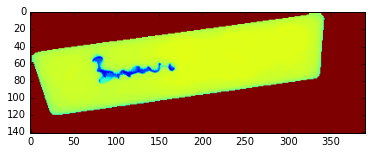

In [7]:
img = writing1.copy()
method = cv2.TM_SQDIFF
w, h = writing1.shape[::-1]
res = cv2.matchTemplate(writingb,writing1,method)
min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)
top_left = min_loc
bottom_right = (top_left[0] + w, top_left[1] + h)
cv2.rectangle(img,top_left, bottom_right, 255, 2)
print(top_left, bottom_right)
plt.imshow(img)

(0, 0) (390, 141)


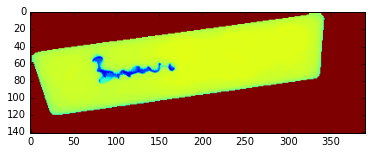

In [8]:
img = writing1.copy()
method = cv2.TM_SQDIFF
w, h = writing1.shape[::-1]
res = cv2.matchTemplate(empty,writing1,method)
min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)
top_left = min_loc
bottom_right = (top_left[0] + w, top_left[1] + h)
cv2.rectangle(img,top_left, bottom_right, 255, 2)
print(top_left, bottom_right)
plt.imshow(img)

so the first result (2 up ) sounds like the whole img got recognized, great.  but retrying it with empty show we recognize nothing.

i think we should:
- straighten out the image
- take a template just around the word bravo
- then match against a straightened target image
- the straightening may not be nec (may you write crooked) but template matching is on rects.


### Let's try this out with a hand made template


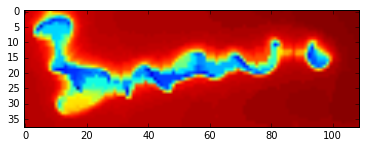

In [14]:
template = cv2.imread('tt.png')  # used gimp to cut it 
template = cv2.cvtColor(template, cv2.COLOR_BGR2GRAY)
plt.imshow(template)

min_val, res.min, res.max: 1.6e-05 16.0 4.14318e+07


16.0

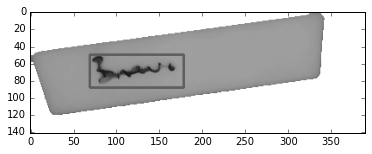

In [151]:
def frame_img(img, dim):
    "put image in a black frame so resulting image has shape dim"
    framed = np.zeros(dim, dtype=img.dtype)
    jx, jy = np.trunc((np.array(dim)  - np.array(img.shape))/2).astype(int)
    assert jx>0 and jy>0, "Image must be smaller than desired dimensions"
    framed[jx:jx+img.shape[0], jy:jy+img.shape[1]] = img
    return framed


def locate_template(img, template):
    "Find template in image and produce stats + image "
    img1 = img.copy()
    method = cv2.TM_SQDIFF
    w, h = template.shape[::-1]

    res = cv2.matchTemplate(template,img1,method)
    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)
    top_left = min_loc
    bottom_right = (top_left[0] + w, top_left[1] + h)
    cv2.rectangle(img1,top_left, bottom_right, 128, 2)
    print("min_val, res.min, res.max:", min_val/1e6, res.min(), res.max())
    #framed = frame_img(res, img1.shape)
    # this does not work because the scale (min-max) of framed is very different from res. 
    #plt.imshow(np.concatenate([img1.astype(np.float32)*np.mean(framed), framed.astype(np.float32)]), cmap="gray")
    plt.imshow(img1.astype(np.float32), cmap="gray")
    return min_val, img1
    
value, _ = locate_template(writing1, template)
value

min_val, res.min, res.max: 0.057672 57672.0 4.14318e+07


'value 5.77e+04'

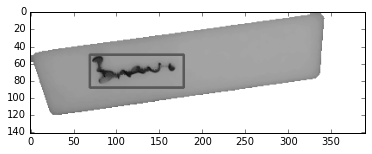

In [165]:
value, _ = locate_template(writingb, template)
"value %2.2e" % value

min_val, res.min, res.max: 0.0378 37800.0 4.14318e+07


'value 3.78e+04'

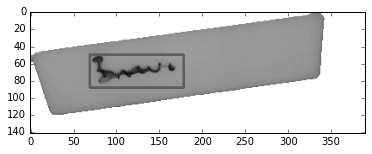

In [164]:
value, _ = locate_template(writingc, template)
"value %2.2e" % value

min_val, res.min, res.max: 4.091304 4.0913e+06 4.14318e+07


'value 4.09e+06'

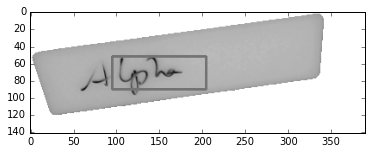

In [163]:
value, _ = locate_template(writing2, template)
"value %2.2e" % value

min_val, res.min, res.max: 5.699736 5.69974e+06 4.14318e+07


'value 5.70e+06'

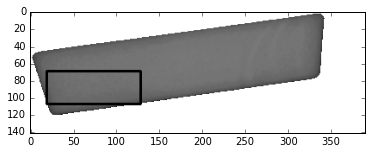

In [162]:
value, _ = locate_template(empty, template)
"value %2.2e" % value